# Stock Market Time Series Analysis
## Importing libraries and data

In [135]:
import datetime as dt
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
#import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [136]:
# Choose BlackRock stock ticker in the portfolio
ticker = ['BLK']
end_date = dt.datetime(2023, 1, 1)
start_date = end_date - dt.timedelta(days=2 * 365)

In [137]:
# Importing price data from yahoo finance
df = yf.download(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-01-04 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       503 non-null    float64
 1   High       503 non-null    float64
 2   Low        503 non-null    float64
 3   Close      503 non-null    float64
 4   Adj Close  503 non-null    float64
 5   Volume     503 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


## Periodic Resampling
Implementing resampling method to aggregate data based on some frequency (monthly, quarterly, etc.).

In [140]:
df.resample(rule='A').mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-31,846.213334,853.609443,838.321907,846.090596,787.079745,564833.333333
2022-12-31,688.654621,697.716534,679.063546,688.331991,654.410996,850777.689243


In [142]:
df.shift(periods=1).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,730.599976,730.599976,702.039978,710.820007,654.714294,623600.0
2021-01-06,708.809998,717.210022,705.260010,714.580017,658.177490,431400.0
2021-01-07,718.760010,744.789978,716.099976,734.960022,676.949036,730700.0
2021-01-08,748.340027,753.270020,743.010010,750.419983,691.188782,656000.0


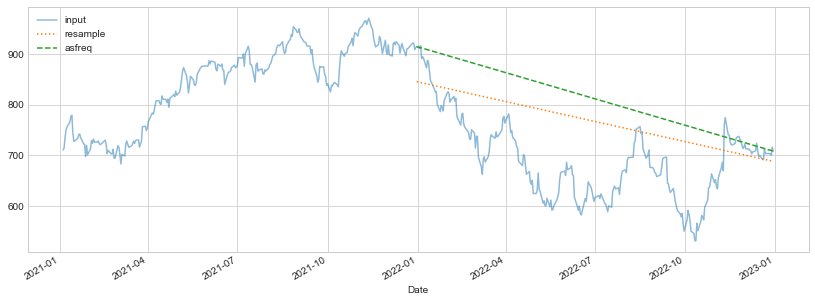

In [143]:
df_close = df['Close']
df_close.plot(figsize=(14, 5),alpha=0.5, style='-')
df_close.resample('BA').mean().plot(style=':')
df_close.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

<AxesSubplot:xlabel='Date'>

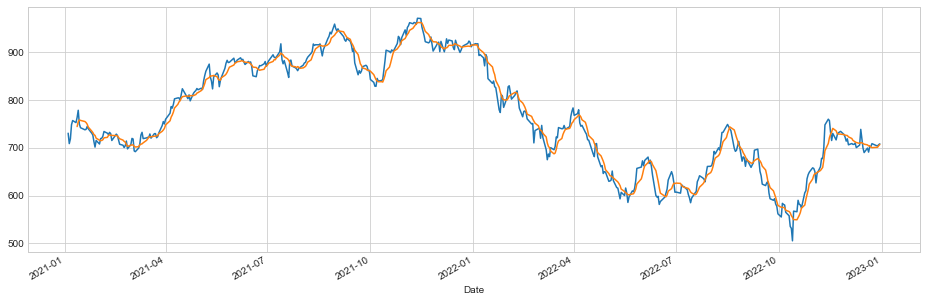

In [144]:
# Calculation the rolling 7-day Close price
df['Open'].plot()
df.rolling(7).mean()['Close'].plot(figsize=(16, 5))

<AxesSubplot:xlabel='Date'>

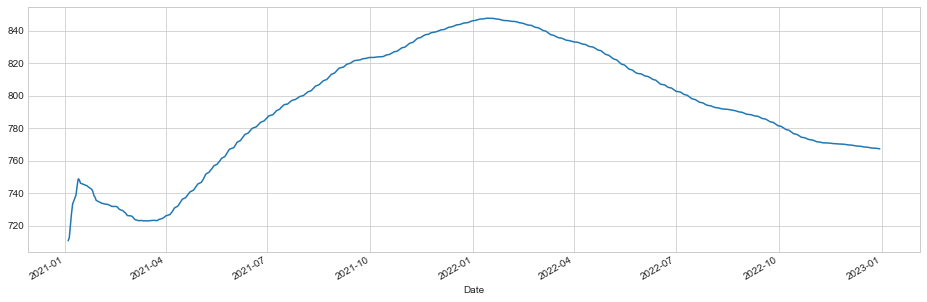

In [145]:
# Expanding average close price
df['Close'].expanding().mean().plot(figsize=(16, 5))

## Bollinger Bands
Bollinger Bands are a popular technical analysis tool used to determine the volatility of a financial instrument. 
They consist of a simple moving average (SMA) and two standard deviation lines (bands) plotted above and below the SMA.

<AxesSubplot:xlabel='Date'>

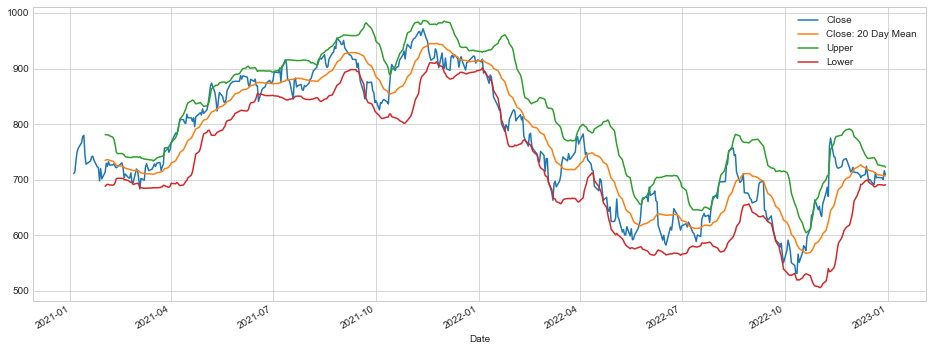

In [146]:
# Close 20 MA (M)
df['Close: 20 Day Mean'] = df['Close'].rolling(20).mean()

# Upper = 20MA + 2*std(20)
df['Upper'] = df['Close: 20 Day Mean'] + 2 * (df['Close'].rolling(20).std())

# Lower = 20MA - 2*std(20)
df['Lower'] = df['Close: 20 Day Mean'] - 2 * (df['Close'].rolling(20).std())

# Plot Close
df[['Close', 'Close: 20 Day Mean', 'Upper', 'Lower']].plot(figsize=(16, 6))

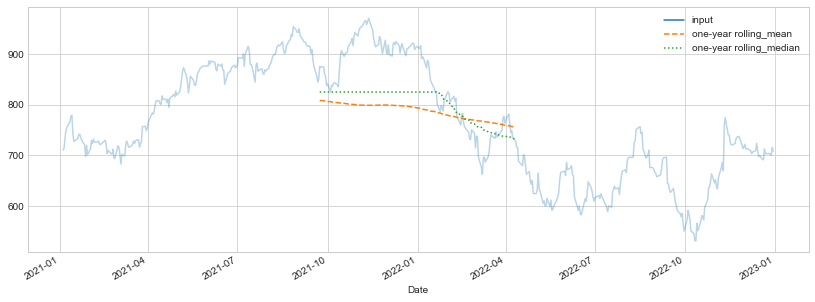

In [147]:
rolling = df_close.rolling(365, center=True)

data = pd.DataFrame({'input': df_close,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_median': rolling.median()})
ax = data.plot(figsize=(14, 5),style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

# Time Series Analysis
## ETS model (Error-Trend-Seasonality)

In [148]:
result = seasonal_decompose(df['Adj Close'], model='additive', period=12)

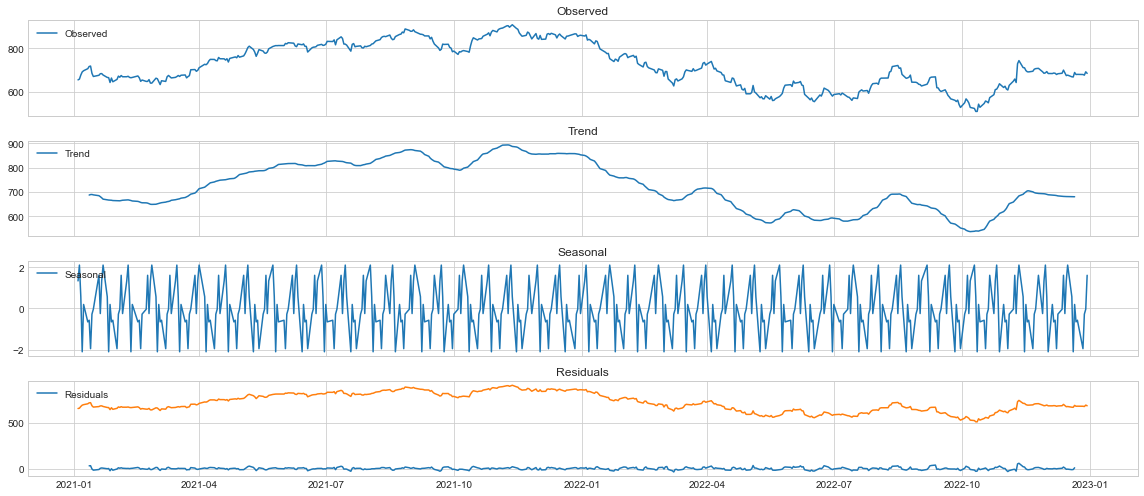

In [149]:
trend = result.trend
seasonal = result.seasonal
residuals = result.resid
observed = result.observed

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(16, 7), sharex=True)
ax1.plot(observed, label='Observed')
ax1.set_title('Observed')
ax1.legend(loc='upper left')

ax2.plot(trend, label='Trend')
ax2.set_title('Trend')
ax2.legend(loc='upper left')

ax3.plot(seasonal, label='Seasonal')
ax3.set_title('Seasonal')
ax3.legend(loc='upper left')

ax4.plot(residuals, label='Residuals')
ax4.set_title('Residuals')
ax4.legend(loc='upper left')
plt.tight_layout()
ax4.plot(observed)

## SME (Simple Moving Averages)


<AxesSubplot:xlabel='Date'>

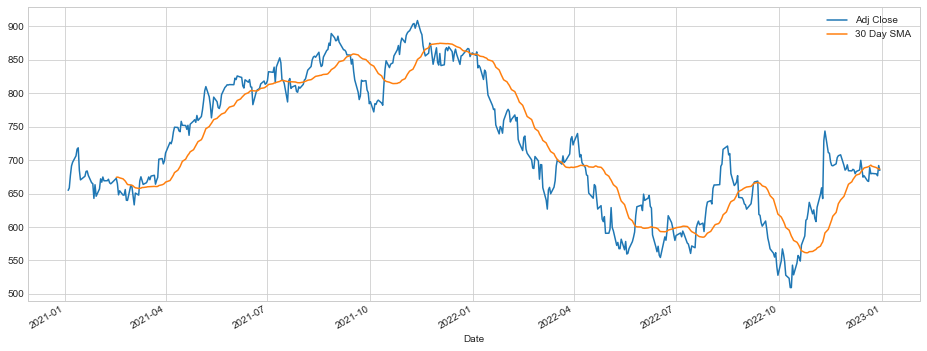

In [150]:
# creating SME (Simple Moving Averages)
df['30 Day SMA'] = df['Adj Close'].rolling(window=30).mean()
df[['Adj Close', '30 Day SMA']].plot(figsize=(16, 6))

## EWMA (Exponentially Weighted Moving Averages)
The moving average is designed as such that older observations are given lower weights. The weights fall exponentially as the data point gets older – hence the name exponentially weighted.

The only decision a user of the EWMA must make is the parameter alpha. The higher the value of alpha, the more closely the EWMA tracks the original time series.

<AxesSubplot:xlabel='Date'>

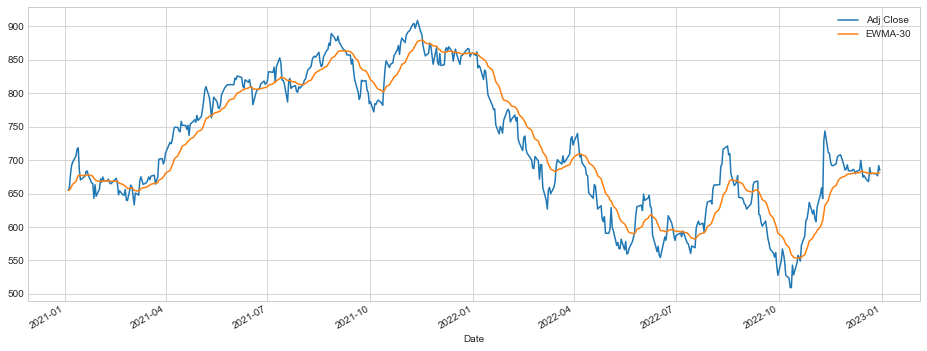

In [151]:
# creating EWMA (Exponentially Weighted Moving Averages)
df['EWMA-30'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
df[['Adj Close', 'EWMA-30']].plot(figsize=(16, 6))

## Converting Frequencies
Since Stock Market data is only available for business days, the top panel contains gaps indicating NA values. The bottom panel compares two methods for filling these gaps: forward filling and backward filling.

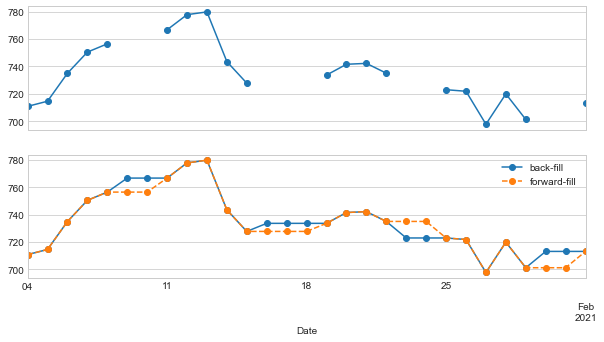

In [152]:
fig, ax = plt.subplots(2, sharex=True)
data = df_close.iloc[:20]

data.asfreq('D').plot(figsize=(10, 5),ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

## Calculating ROI (Return on Investment)
ROI is calculated by dividing the net profit from the investment by the initial cost of the investment, and it is usually expressed as a percentage.

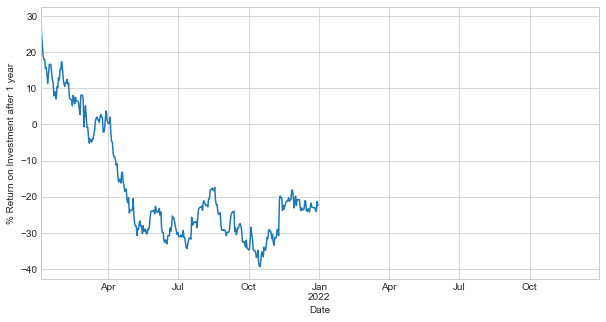

In [153]:
df_close = df_close.asfreq('D', method='pad')

ROI = 100 * (df_close.shift(-365) - df_close) / df_close
ROI.plot(figsize=(10, 5))
plt.ylabel('% Return on Investment after 1 year');

## Overview
This research demonstrates the ability to implement Time Series Analysis on stock market data.
Through the project indicators were calculated:
1. Datetime Indexing: Converting dates into Pandas datetime objects.
2. Resampling: Changing the frequency of time series data (e.g., daily to monthly).
3. Time Shifts: Shifting data in time to create lagged series.
4. Rolling Windows: Applying functions over moving time windows.
5. Handling Missing Data: Using forward and backward filling techniques.